In [1]:
import statsapi
from datetime import date, timedelta, datetime
import requests
import json
import matplotlib.pyplot as plt
from collections import defaultdict
from pprint import pprint
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [2]:
# File paths, date constants 
PLAYER_STATS_FOLDER = 'stats/player/'
TEAM_STATS_FOLDER = 'stats/team/'
TODAY = date.today()
YESTERDAY = TODAY - timedelta(days = 1)
SUNDAY = TODAY - timedelta(days=TODAY.weekday())

In [3]:
#Set start/end dates
start_date = date(2021,3,1)
end_date = YESTERDAY
seasons = list(range(start_date.year, end_date.year + 1)) #List of all seasons in range start:end date
print(seasons)

[2021, 2022, 2023, 2024, 2025]


In [4]:
#Pitcher info
pitcher = "Tarik Skubal"
pitcher_id = 669373
his_games = []

In [5]:
#Just get the given pitcher's gamePks
#Only run this once
url = f"https://statsapi.mlb.com/api/v1/people/{pitcher_id}/stats"
for currentSeason in seasons:
    params = {
        "stats": "gameLog",
        "group": "pitching",
        "season": currentSeason
    }
    response = requests.get(url, params=params)
    all_games = response.json()
    
    for game in all_games['stats'][0]['splits']:
        his_games.append(game['game']['gamePk'])
print(his_games)

[634611, 632218, 634632, 634390, 634448, 634327, 634204, 634206, 634046, 633970, 633854, 633920, 633789, 633612, 633526, 633494, 633442, 633359, 633212, 633183, 633107, 633026, 632922, 632861, 632751, 632688, 632585, 632512, 632427, 632347, 632285, 662887, 662701, 662848, 661729, 662816, 662412, 662843, 663135, 662842, 662833, 662449, 662829, 662826, 663252, 662060, 662794, 661412, 662659, 662411, 662900, 661671, 717494, 717431, 717356, 718558, 717202, 717122, 717042, 716956, 716885, 716795, 716734, 716658, 716570, 716488, 716414, 746821, 746497, 746491, 746487, 745107, 746483, 745751, 746480, 747201, 746304, 746467, 745009, 746463, 746378, 747106, 746454, 745886, 746691, 746450, 746612, 746446, 746443, 745223, 746435, 746431, 746756, 746424, 745611, 746427, 746254, 746421, 778546, 778469, 778403, 778323, 778246, 778155, 778085, 777996, 777927, 777840, 777780, 777694, 777626, 777540, 777451, 777386, 777314, 777226, 777161, 777073, 777003, 776912]


In [6]:
#Setup

def is_valid_pitch(event):
    event_type = event.get("type")
    is_pitch_type = event_type == 'pitch'
    return is_pitch_type


def his_pitch(event):
    event_pitcher_id = event.get('matchup',{}).get('pitcher',{}).get('id')
    return pitcher_id == event_pitcher_id

In [9]:
atbats = defaultdict(list) #Pitch sequence grouped by atbats

    
for gamePk in his_games:
    pbp = statsapi.get("game_playByPlay", params={"gamePk": gamePk})
    all_plays = pbp['allPlays']
    for atbat in all_plays:
        sequence = []
        index = atbat['atBatIndex']
        for event in atbat.get("playEvents", []):
            if not is_valid_pitch(event) or not his_pitch(atbat):
                continue
            else:
                # Extract relevant pitch info
                playId = event.get("playId","")
                count = event.get("count", {})
                pitchIndex = event.get("pitchNumber"),
                pitchIndex=pitchIndex[0]
                # Append to context
                sequence.append({
                    "atBatIndex": index,
                    "balls": count.get("balls", 0),
                    "strikes": count.get("strikes", 0),
                    "outs": count.get("outs", 0),
                    # "result": event.get("details", {}).get("description", ""),
                    "pitchType": event.get("details", {}).get("type", {}).get("description", ""),
                    "speed": event.get("pitchData", {}).get("startSpeed", None),
                    "batter": atbat["matchup"]["batter"]["id"],
                    # "batter_side": atbat['matchup']['batSide']['code'],
                    # "result": atbat["result"]["eventType"],
                    "type_confidence":event.get("pitchData",{}).get('typeConfidence',{})
                })
            if sequence:
                key = (gamePk, index, pitchIndex)  
                atbats[key] = sequence
        
unique_pitches = set(p['pitchType'] for pitches in atbats.values() for p in pitches)
result_types = set(p.get('result')) for pitches in atbats.values() for p in atbats.values() 




SyntaxError: invalid syntax (856482728.py, line 38)

In [ ]:
pitch_vocab = sorted([p for p in unique_pitches if p.strip() != ''])
pitch_to_idx = {p: i for i, p in enumerate(pitch_vocab)}
idx_to_pitch = {i: p for p, i in pitch_to_idx.items()}
pprint(pitch_to_idx)
result_map = {r: i for i, r in enumerate(sorted(result_types))}
print(result_map)

(776912, 57, 7)
{'atBatIndex': 57,
 'balls': 1,
 'batter': 624641,
 'outs': 2,
 'pitchType': 'Four-Seam Fastball',
 'speed': 97.9,
 'strikes': 0,
 'type_confidence': 2.0}


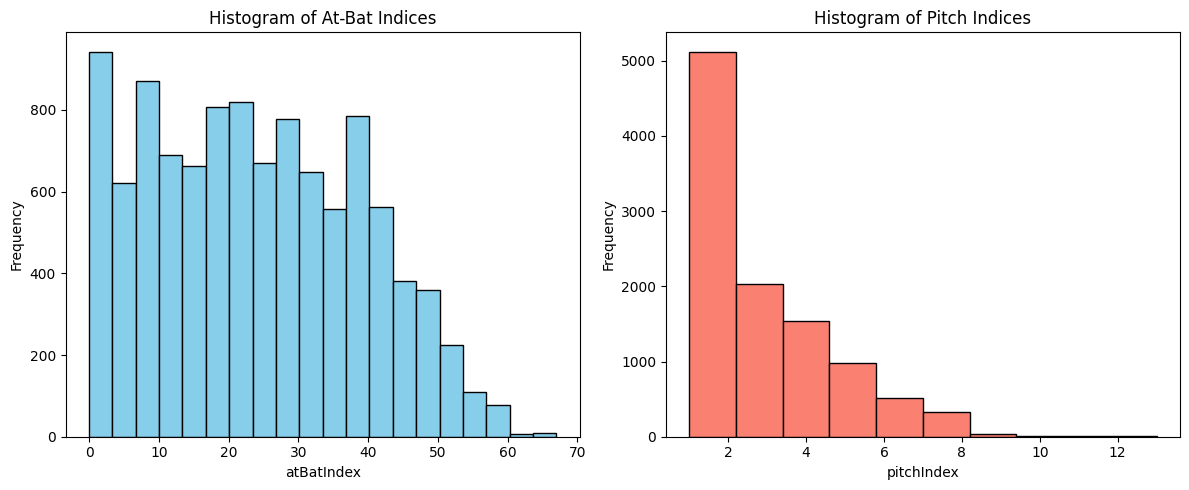

In [68]:
#Test
testkey = 0
atbat_indices = []
pitch_indices = []
for key in atbats.keys():
    testkey = key
    atbat_indices.append(testkey[1])
    pitch_indices.append(testkey[2])
print(testkey)
pprint(atbats.get(testkey)[0])

plt.figure(figsize=(12, 5))

# AtBatIndex histogram
plt.subplot(1, 2, 1)
plt.hist(atbat_indices, bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram of At-Bat Indices")
plt.xlabel("atBatIndex")
plt.ylabel("Frequency")

# PitchIndex histogram
plt.subplot(1, 2, 2)
plt.hist(pitch_indices, bins=10, color='salmon', edgecolor='black')
plt.title("Histogram of Pitch Indices")
plt.xlabel("pitchIndex")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [70]:
def pitch_to_vec(event, class_map={}):
    vec = []

    # Categorical: pitch type
    pitch_type = event.get("pitchType", "").strip()
    pitch_idx = class_map.get(pitch_type, -1)  # Use -1 or len(class_map) as default for unknowns
    vec.append(pitch_idx)

    # Numeric features (replace or expand as needed)
    vec.append(event.get("balls", 0))
    vec.append(event.get("strikes", 0))
    vec.append(event.get("outs", 0))

    speed = event.get("speed", None)
    vec.append(speed if speed is not None else 0.0)

    # Optional: batter side (categorical)
    batter_side = event.get("batter_side", "").strip()
    batter_side_map = {"L": 0, "R": 1, "S": 2}
    vec.append(batter_side_map.get(batter_side, -1))

    # Optional: pitch confidence (some models benefit from this)
    confidence = event.get("type_confidnce", 0.0)
    vec.append(confidence if confidence is not None else 0.0)

    return vec

#Testing
test_pitch=atbats.get(testkey)[0]
print(pitch_to_vec(test_pitch, pitch_to_idx))

[5, 1, 0, 2, 97.9, -1, 0.0]


In [71]:


class PitchDataset(Dataset):
    def __init__(self, atbat_dict, result_map, class_map):
        self.samples = []

        for atbat_key, pitches in atbat_dict.items():
            if len(pitches) < 2:
                continue  # skip short at-bats

            result_str = pitches[-1]['result']
            if result_str not in result_map:
                continue
            y_result = result_map[result_str]

            seq = [pitch_to_vec(p, class_map) for p in pitches]

            # Create growing input sequences
            for i in range(1, len(seq)):  # avoid full seq predicting itself
                x_seq = seq[:i]
                self.samples.append((x_seq, y_result))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x_seq, y_result = self.samples[idx]
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_result, dtype=torch.long)


#Collate fn - pads sequences (at bats) so they are the same length
def collate_fn(batch):
    x_seqs, y = zip(*batch)
    x_padded = pad_sequence(x_seqs, batch_first=True)  # (batch, seq_len, feature_dim)
    y = torch.stack(y)
    return x_padded, y

In [72]:

#atbats: dict of {at-bat ID: list of pitches}
#result_map: a mapping from string labels (e.g., "strikeout", "walk", etc.) to integer class labels

dataset = PitchDataset(atbats, pitch_to_idx)
loader = DataLoader(atbats, batch_size=32, shuffle=True, collate_fn=collate_fn)

TypeError: PitchDataset.__init__() missing 1 required positional argument: 'class_map'

In [ ]:
class LSTMPitchModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=1, dropout=-0.1):
        super(LSTMPitchModel, self).__init__()

        self.lstm = nn.LSTM (
            input_size = input_dim,
            hidden_size = hidden_dim,
            num_layers = num_layers,
            batch_first=True,
            dropout = dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, lengths):
        packed_x = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, _) = self.lstm(packed_x)
        final_hidden = hidden[-1]
        out = self.fc(final_hidden)
        return out

    

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMPitchModel(input_dim=num_classes=len(pitch_vocab)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(10):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        loss = loss_fn(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

In [ ]:
def predict_next(model, context_seq):
    model.eval()
    with torch.no_grad():
        x = torch.tensor([[pitch_to_idx[p] for p in context_seq]]).to(device)
        logits = model(x)
        probs = torch.softmax(logits, dim=-1)
        predicted_idx = torch.argmax(probs, dim=-1).item()
        return idx_to_pitch[predicted_idx]

print(predict_next(model, ["FF", "SL", "CH"]))  # → likely "CU"